In [21]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import numpy as np
from datetime import datetime
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import json


def extract_features_from_loader(loader, model, device):
    """
    Extract features using the CNN model's feature extractor.
    """
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, batch_labels in loader:
            images = images.to(device)
            feature_batch = model.features(images).view(images.size(0), -1).cpu().numpy()
            features.append(feature_batch)
            labels.append(batch_labels.numpy())
    return np.vstack(features), np.concatenate(labels)



# Original CIFAR100 Feature Extractor and Classifier (keeping exactly as is)
class CIFAR100Classifier(nn.Module):
    def __init__(self):
        super(CIFAR100Classifier, self).__init__()
        
        # More straightforward CNN architecture
        self.features = nn.Sequential(
            # First block - keep spatial dimensions
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 16x16
            
            # Second block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 8x8
            
            # Third block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 4x4
            
            # Fourth block
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1)  # Global average pooling
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 100)  # Direct classification
        )
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        features = self.features(x)
        output = self.classifier(features)
        return output

# New GTSRB Classifier (following similar architecture but with 43 classes)
class GTSRBClassifier(nn.Module):
    def __init__(self):
        super(GTSRBClassifier, self).__init__()
        
        self.features = nn.Sequential(
            # First block
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Second block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Third block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Fourth block
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 43)  # GTSRB has 43 classes
        )
        
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        features = self.features(x)
        output = self.classifier(features)
        return output

# New Imagenette Classifier (10 classes)
class ImagenetteClassifier(nn.Module):
    def __init__(self):
        super(ImagenetteClassifier, self).__init__()
        
        self.features = nn.Sequential(
            # First block
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Second block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Third block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Fourth block
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 10)  # Imagenette has 10 classes
        )
        
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        features = self.features(x)
        output = self.classifier(features)
        return output

In [22]:
# Original CIFAR100 transforms (keeping exactly as is)
def get_cifar_transforms():
    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.RandAugment(num_ops=2, magnitude=9),
        transforms.ColorJitter(
            brightness=0.2,
            contrast=0.2,
            saturation=0.2
        ),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.5071, 0.4867, 0.4408],
            std=[0.2675, 0.2565, 0.2761]
        ),
        transforms.RandomErasing(p=0.2)
    ])
    
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.5071, 0.4867, 0.4408],
            std=[0.2675, 0.2565, 0.2761]
        )
    ])
    
    return train_transform, test_transform

# New GTSRB transforms
def get_gtsrb_transforms():
    train_transform = transforms.Compose([
        transforms.Resize((64, 64)),  # GTSRB images are variable size
        transforms.RandomRotation(15),
        transforms.RandomAffine(0, translate=(0.1, 0.1), scale=(0.8, 1.2)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.3398, 0.3117, 0.3210],
                           std=[0.2755, 0.2647, 0.2712])
    ])
    
    test_transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.3398, 0.3117, 0.3210],
                           std=[0.2755, 0.2647, 0.2712])
    ])
    
    return train_transform, test_transform

# New Imagenette transforms
def get_imagenette_transforms():
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])
    
    test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])
    
    return train_transform, test_transform

def load_cifar100(batch_size=128, num_workers=2):
    """Load CIFAR100 dataset using original transforms"""
    train_transform, test_transform = get_cifar_transforms()
    
    train_dataset = torchvision.datasets.CIFAR100(
        root='./data', train=True, download=True, transform=train_transform
    )
    test_dataset = torchvision.datasets.CIFAR100(
        root='./data', train=False, download=True, transform=test_transform
    )
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=True
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=True
    )
    
    return train_loader, test_loader

def load_gtsrb(batch_size=128, num_workers=2):
    """Load GTSRB dataset"""
    train_transform, test_transform = get_gtsrb_transforms()
    
    train_dataset = torchvision.datasets.GTSRB(
        root='./data', split='train', download=True,
        transform=train_transform
    )
    test_dataset = torchvision.datasets.GTSRB(
        root='./data', split='test', download=True,
        transform=test_transform
    )
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=True
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=True
    )
    
    return train_loader, test_loader

def load_imagenette(batch_size=128, num_workers=2, data_dir='./data/imagenette2'):
    """Load Imagenette dataset from directory"""
    train_transform, test_transform = get_imagenette_transforms()
    
    train_dataset = torchvision.datasets.ImageFolder(
        root=os.path.join(data_dir, 'train'),
        transform=train_transform
    )
    test_dataset = torchvision.datasets.ImageFolder(
        root=os.path.join(data_dir, 'val'),
        transform=test_transform
    )
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=True
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=True
    )
    
    return train_loader, test_loader

def get_dataset_loaders(dataset_name, batch_size=128, num_workers=1):
    """Unified function to get data loaders for any dataset"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Loading {dataset_name} dataset...")
    
    if dataset_name.lower() == 'cifar100':
        train_transform, test_transform = get_cifar_transforms()
        
        train_dataset = torchvision.datasets.CIFAR100(
            root='./data', train=True, download=True, transform=train_transform
        )
        test_dataset = torchvision.datasets.CIFAR100(
            root='./data', train=False, download=True, transform=test_transform
        )
        
        # Standard DataLoader settings for CIFAR100
        train_loader = torch.utils.data.DataLoader(
            train_dataset, 
            batch_size=batch_size, 
            shuffle=True,
            num_workers=num_workers, 
            pin_memory=True
        )
        
        test_loader = torch.utils.data.DataLoader(
            test_dataset, 
            batch_size=batch_size, 
            shuffle=False,
            num_workers=num_workers, 
            pin_memory=True
        )
        
    elif dataset_name.lower() == 'gtsrb':
        train_transform, test_transform = get_gtsrb_transforms()
        
        train_dataset = torchvision.datasets.GTSRB(
            root='./data', split='train', download=True, transform=train_transform
        )
        test_dataset = torchvision.datasets.GTSRB(
            root='./data', split='test', download=True, transform=test_transform
        )
        
        # Standard DataLoader settings for GTSRB
        train_loader = torch.utils.data.DataLoader(
            train_dataset, 
            batch_size=batch_size, 
            shuffle=True,
            num_workers=num_workers, 
            pin_memory=True
        )
        
        test_loader = torch.utils.data.DataLoader(
            test_dataset, 
            batch_size=batch_size, 
            shuffle=False,
            num_workers=num_workers, 
            pin_memory=True
        )
        
    elif dataset_name.lower() == 'imagenette':
        train_transform, test_transform = get_imagenette_transforms()
        
        # Using FastAI's Imagenette dataset directly
        root_dir = './data'
        if not os.path.exists(os.path.join(root_dir, 'imagenette2-320')):
            # Download and extract Imagenette (same as before)
            import urllib.request
            import tarfile
            
            os.makedirs(root_dir, exist_ok=True)
            print("Downloading Imagenette dataset...")
            url = 'https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz'
            filename = os.path.join(root_dir, 'imagenette2-320.tgz')
            
            urllib.request.urlretrieve(url, filename)
            
            print("Extracting dataset...")
            with tarfile.open(filename, 'r:gz') as tar:
                def is_within_directory(directory, target):
                    abs_directory = os.path.abspath(directory)
                    abs_target = os.path.abspath(target)
                    prefix = os.path.commonprefix([abs_directory, abs_target])
                    return prefix == abs_directory

                def safe_extract(tar, path="./data"):
                    for member in tar.getmembers():
                        member_path = os.path.join(path, member.name)
                        if not is_within_directory(path, member_path):
                            raise Exception("Attempted Path Traversal in Tar File")
                    tar.extractall(path)
                
                safe_extract(tar, root_dir)
            
            os.remove(filename)
            print("Dataset ready!")
        
        train_dataset = torchvision.datasets.ImageFolder(
            root=os.path.join(root_dir, 'imagenette2-320/train'),
            transform=train_transform
        )
        
        test_dataset = torchvision.datasets.ImageFolder(
            root=os.path.join(root_dir, 'imagenette2-320/val'),
            transform=test_transform
        )
        
        # Modified DataLoader settings for Imagenette
        # Reduced batch size and number of workers, added prefetch factor
        imagenette_batch_size = batch_size // 2  # Reduce batch size for larger images
        imagenette_workers = 1  # Reduce number of workers
        
        train_loader = torch.utils.data.DataLoader(
            train_dataset, 
            batch_size=imagenette_batch_size, 
            shuffle=True,
            num_workers=imagenette_workers, 
            pin_memory=True,
            prefetch_factor=2,  # Reduce prefetch factor
            persistent_workers=True  # Keep workers alive between iterations
        )
        
        test_loader = torch.utils.data.DataLoader(
            test_dataset, 
            batch_size=imagenette_batch_size, 
            shuffle=False,
            num_workers=imagenette_workers, 
            pin_memory=True,
            prefetch_factor=2,
            persistent_workers=True
        )
    
    else:
        raise ValueError(f"Unknown dataset: {dataset_name}")
    
    print(f"Dataset loaded with {len(train_dataset)} training and {len(test_dataset)} test samples")
    if dataset_name.lower() == 'imagenette':
        print(f"Using batch size {imagenette_batch_size} and {imagenette_workers} workers for Imagenette")
    
    return train_loader, test_loader

In [ ]:
# Keep the original CIFAR100 training function exactly as is
def train_cifar(model, train_loader, test_loader, epochs=30, device='cuda'):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.05)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    best_acc = 0.0
    model = model.to(device)
    
    for epoch in range(epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, (images, labels) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            if i % 100 == 99:
                print(f'Loss: {running_loss/100:.3f} | Acc: {100.*correct/total:.2f}%')
                running_loss = 0.0
        
        scheduler.step()
        
        # Testing
        model.eval()
        test_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        acc = 100.*correct/total
        print(f'\nTest Accuracy: {acc:.2f}%')
        
        if acc > best_acc:
            best_acc = acc
            print(f'New best accuracy: {best_acc:.2f}%')
    
    return model, best_acc

# Training function for GTSRB (similar structure but with dataset-specific optimizations)
def train_gtsrb(model, train_loader, test_loader, epochs=30, device='cuda'):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.05)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    best_acc = 0.0
    model = model.to(device)
    
    for epoch in range(epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, (images, labels) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            if i % 50 == 49:  # More frequent updates due to smaller dataset
                print(f'Loss: {running_loss/50:.3f} | Acc: {100.*correct/total:.2f}%')
                running_loss = 0.0
        
        scheduler.step()
        
        # Testing
        model.eval()
        test_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        acc = 100.*correct/total
        print(f'\nTest Accuracy: {acc:.2f}%')
        
        if acc > best_acc:
            best_acc = acc
            print(f'New best accuracy: {best_acc:.2f}%')
    
    return model, best_acc

# Training function for Imagenette
def train_imagenette(model, train_loader, test_loader, epochs=30, device='cuda'):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.05)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    best_acc = 0.0
    model = model.to(device)
    
    for epoch in range(epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, (images, labels) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            if i % 20 == 19:  # More frequent updates for Imagenette
                print(f'Loss: {running_loss/20:.3f} | Acc: {100.*correct/total:.2f}%')
                running_loss = 0.0
        
        scheduler.step()
        
        # Testing
        model.eval()
        test_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        acc = 100.*correct/total
        print(f'\nTest Accuracy: {acc:.2f}%')
        
        if acc > best_acc:
            best_acc = acc
            print(f'New best accuracy: {best_acc:.2f}%')
    
    return model, best_acc

def train_model(dataset_name, model, train_loader, test_loader, epochs=30, device='cuda'):
    """Unified function to train any dataset's model"""
    if dataset_name.lower() == 'cifar100':
        return train_cifar(model, train_loader, test_loader, epochs, device)
    elif dataset_name.lower() == 'gtsrb':
        return train_gtsrb(model, train_loader, test_loader, epochs, device)
    elif dataset_name.lower() == 'imagenette':
        return train_imagenette(model, train_loader, test_loader, epochs, device)
    else:
        raise ValueError(f"Unknown dataset: {dataset_name}")

def get_model(dataset_name):
    """Get the appropriate model for the dataset"""
    if dataset_name.lower() == 'cifar100':
        return CIFAR100Classifier()
    elif dataset_name.lower() == 'gtsrb':
        return GTSRBClassifier()
    elif dataset_name.lower() == 'imagenette':
        return ImagenetteClassifier()
    else:
        raise ValueError(f"Unknown dataset: {dataset_name}")

def main():
    # Configuration
    batch_size = 128
    epochs = 30
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    datasets = ['cifar100','gtsrb','imagenette']
    
    # Initialize results dictionary
    all_results = {}
    
    # Loop over datasets
    for dataset_name in datasets:
        print(f"\nProcessing dataset: {dataset_name}")
        all_results[dataset_name] = {"classifiers": {}}
        
        # Get data loaders
        train_loader, test_loader = get_dataset_loaders(dataset_name, batch_size)
        
        # Get CNN model for feature extraction
        model = get_model(dataset_name)
        model = model.to(device)
        
        # Train the CNN model
        print(f"Training CNN model on {dataset_name}")
        trained_model, best_acc = train_model(dataset_name, model, train_loader, test_loader, epochs, device)
        
        # Save the trained CNN model
        results_dir = "results"
        os.makedirs(results_dir, exist_ok=True)
        model_path = os.path.join(results_dir, f"{dataset_name}_model.pth")
        torch.save(trained_model.state_dict(), model_path)
        print(f"Trained model saved to: {model_path}")
        
        # Extract features using the trained CNN model
        print("Extracting features for classical classifiers...")
        train_features, train_labels = extract_features_from_loader(train_loader, trained_model, device)
        test_features, test_labels = extract_features_from_loader(test_loader, trained_model, device)
        
        # Classical classifiers
        classifiers = {
            "Logistic Regression": LogisticRegression(max_iter=1000),
            "SVM": SVC(),
            "Random Forest": RandomForestClassifier(),
            "K-Nearest Neighbors": KNeighborsClassifier(),
        }
        
        for clf_name, clf in classifiers.items():
            print(f"Training and evaluating {clf_name}")
            clf.fit(train_features, train_labels)
            acc = clf.score(test_features, test_labels)
            all_results[dataset_name]["classifiers"][clf_name] = acc
            print(f"{clf_name} Accuracy: {acc:.4f}")
        
        # Save results JSON
        results_path = os.path.join(results_dir, f"{dataset_name}_results.json")
        with open(results_path, 'w') as f:
            json.dump(all_results[dataset_name], f, indent=4)
        
        print(f"Results saved in {results_dir} as {dataset_name}_results.json")
    
    print("\nAll processing complete.")

            
        

if __name__ == "__main__":
    main()


Processing dataset: cifar100
Loading cifar100 dataset...
Files already downloaded and verified
Files already downloaded and verified
Dataset loaded with 50000 training and 10000 test samples
Training CNN model on cifar100


Epoch 1/30:  26%|███████████▎                                | 101/391 [00:15<00:47,  6.07it/s]

Loss: 4.304 | Acc: 4.30%


Epoch 1/30:  51%|██████████████████████▌                     | 201/391 [00:31<00:29,  6.40it/s]

Loss: 4.032 | Acc: 5.87%


Epoch 1/30:  77%|█████████████████████████████████▊          | 301/391 [00:47<00:13,  6.67it/s]

Loss: 3.849 | Acc: 7.13%


Epoch 1/30: 100%|████████████████████████████████████████████| 391/391 [01:01<00:00,  6.35it/s]



Test Accuracy: 12.22%
New best accuracy: 12.22%


Epoch 2/30:  26%|███████████▎                                | 101/391 [00:16<00:47,  6.07it/s]

Loss: 3.536 | Acc: 14.46%


Epoch 2/30:  51%|██████████████████████▌                     | 201/391 [00:32<00:29,  6.50it/s]

Loss: 3.378 | Acc: 16.09%


Epoch 2/30:  77%|█████████████████████████████████▊          | 301/391 [00:48<00:13,  6.51it/s]

Loss: 3.257 | Acc: 17.33%


Epoch 2/30: 100%|████████████████████████████████████████████| 391/391 [01:03<00:00,  6.17it/s]



Test Accuracy: 26.66%
New best accuracy: 26.66%


Epoch 3/30:  26%|███████████▎                                | 101/391 [00:16<00:45,  6.35it/s]

Loss: 3.020 | Acc: 23.52%


Epoch 3/30:  51%|██████████████████████▌                     | 201/391 [00:32<00:29,  6.52it/s]

Loss: 2.909 | Acc: 24.62%


Epoch 3/30:  77%|█████████████████████████████████▊          | 301/391 [00:48<00:13,  6.64it/s]

Loss: 2.827 | Acc: 25.70%


Epoch 3/30: 100%|████████████████████████████████████████████| 391/391 [01:02<00:00,  6.27it/s]



Test Accuracy: 33.01%
New best accuracy: 33.01%


Epoch 4/30:  26%|███████████▎                                | 101/391 [00:16<00:45,  6.37it/s]

Loss: 2.650 | Acc: 31.20%


Epoch 4/30:  51%|██████████████████████▌                     | 201/391 [00:32<00:29,  6.38it/s]

Loss: 2.606 | Acc: 31.76%


Epoch 4/30:  77%|█████████████████████████████████▊          | 301/391 [00:48<00:14,  6.14it/s]

Loss: 2.545 | Acc: 32.27%


Epoch 4/30: 100%|████████████████████████████████████████████| 391/391 [01:02<00:00,  6.26it/s]



Test Accuracy: 39.29%
New best accuracy: 39.29%


Epoch 5/30:  26%|███████████▎                                | 101/391 [00:16<00:47,  6.11it/s]

Loss: 2.451 | Acc: 35.55%


Epoch 5/30:  51%|██████████████████████▌                     | 201/391 [00:32<00:31,  6.01it/s]

Loss: 2.367 | Acc: 36.57%


Epoch 5/30:  77%|█████████████████████████████████▊          | 301/391 [00:49<00:14,  6.08it/s]

Loss: 2.339 | Acc: 37.18%


Epoch 5/30: 100%|████████████████████████████████████████████| 391/391 [01:03<00:00,  6.12it/s]



Test Accuracy: 42.83%
New best accuracy: 42.83%


Epoch 6/30:  26%|███████████▎                                | 101/391 [00:16<00:47,  6.04it/s]

Loss: 2.227 | Acc: 40.42%


Epoch 6/30:  51%|██████████████████████▌                     | 201/391 [00:32<00:30,  6.30it/s]

Loss: 2.189 | Acc: 41.11%


Epoch 6/30:  77%|█████████████████████████████████▊          | 301/391 [00:48<00:14,  6.22it/s]

Loss: 2.171 | Acc: 41.37%


Epoch 6/30: 100%|████████████████████████████████████████████| 391/391 [01:02<00:00,  6.23it/s]



Test Accuracy: 48.26%
New best accuracy: 48.26%


Epoch 7/30:  26%|███████████▎                                | 101/391 [00:16<00:44,  6.56it/s]

Loss: 2.066 | Acc: 44.06%


Epoch 7/30:  51%|██████████████████████▌                     | 201/391 [00:32<00:28,  6.56it/s]

Loss: 2.060 | Acc: 44.13%


Epoch 7/30:  77%|█████████████████████████████████▊          | 301/391 [00:47<00:13,  6.61it/s]

Loss: 2.016 | Acc: 44.59%


Epoch 7/30: 100%|████████████████████████████████████████████| 391/391 [01:02<00:00,  6.28it/s]



Test Accuracy: 49.96%
New best accuracy: 49.96%


Epoch 8/30:  26%|███████████▎                                | 101/391 [00:16<00:50,  5.70it/s]

Loss: 1.929 | Acc: 47.81%


Epoch 8/30:  51%|██████████████████████▌                     | 201/391 [00:32<00:28,  6.56it/s]

Loss: 1.893 | Acc: 47.71%


Epoch 8/30:  77%|█████████████████████████████████▊          | 301/391 [00:49<00:14,  6.02it/s]

Loss: 1.916 | Acc: 47.47%


Epoch 8/30: 100%|████████████████████████████████████████████| 391/391 [01:03<00:00,  6.14it/s]



Test Accuracy: 51.48%
New best accuracy: 51.48%


Epoch 9/30:  26%|███████████▎                                | 101/391 [00:16<00:45,  6.43it/s]

Loss: 1.835 | Acc: 49.46%


Epoch 9/30:  51%|██████████████████████▌                     | 201/391 [00:33<00:30,  6.26it/s]

Loss: 1.815 | Acc: 49.46%


Epoch 9/30:  77%|█████████████████████████████████▊          | 301/391 [00:49<00:14,  6.38it/s]

Loss: 1.822 | Acc: 49.71%


Epoch 9/30: 100%|████████████████████████████████████████████| 391/391 [01:04<00:00,  6.03it/s]



Test Accuracy: 54.26%
New best accuracy: 54.26%


Epoch 10/30:  26%|███████████                                | 101/391 [00:16<00:47,  6.11it/s]

Loss: 1.741 | Acc: 51.69%


Epoch 10/30:  51%|██████████████████████                     | 201/391 [00:32<00:36,  5.20it/s]

Loss: 1.738 | Acc: 51.96%


Epoch 10/30:  77%|█████████████████████████████████          | 301/391 [00:49<00:15,  5.95it/s]

Loss: 1.695 | Acc: 52.34%


Epoch 10/30: 100%|███████████████████████████████████████████| 391/391 [01:04<00:00,  6.10it/s]



Test Accuracy: 54.85%
New best accuracy: 54.85%


Epoch 11/30:  26%|███████████                                | 101/391 [00:16<00:47,  6.09it/s]

Loss: 1.643 | Acc: 53.74%


Epoch 11/30:  51%|█████████████████████▉                     | 200/391 [00:32<00:28,  6.78it/s]

Loss: 1.666 | Acc: 53.66%


Epoch 11/30:  77%|█████████████████████████████████          | 301/391 [00:48<00:14,  6.18it/s]

Loss: 1.640 | Acc: 53.92%


Epoch 11/30: 100%|███████████████████████████████████████████| 391/391 [01:03<00:00,  6.17it/s]



Test Accuracy: 57.02%
New best accuracy: 57.02%


Epoch 12/30:  26%|███████████                                | 101/391 [00:16<00:47,  6.05it/s]

Loss: 1.585 | Acc: 56.03%


Epoch 12/30:  51%|██████████████████████                     | 201/391 [00:32<00:29,  6.39it/s]

Loss: 1.548 | Acc: 56.08%


Epoch 12/30:  77%|█████████████████████████████████          | 301/391 [00:48<00:13,  6.68it/s]

Loss: 1.589 | Acc: 56.08%


Epoch 12/30: 100%|███████████████████████████████████████████| 391/391 [01:03<00:00,  6.20it/s]



Test Accuracy: 58.90%
New best accuracy: 58.90%


Epoch 13/30:  26%|███████████                                | 101/391 [00:16<00:46,  6.25it/s]

Loss: 1.485 | Acc: 58.01%


Epoch 13/30:  51%|██████████████████████                     | 201/391 [00:32<00:32,  5.91it/s]

Loss: 1.507 | Acc: 57.91%


Epoch 13/30:  77%|█████████████████████████████████          | 301/391 [00:49<00:14,  6.20it/s]

Loss: 1.480 | Acc: 58.11%


Epoch 13/30: 100%|███████████████████████████████████████████| 391/391 [01:03<00:00,  6.17it/s]



Test Accuracy: 61.19%
New best accuracy: 61.19%


Epoch 14/30:  26%|███████████                                | 101/391 [00:16<00:48,  5.97it/s]

Loss: 1.418 | Acc: 59.64%


Epoch 14/30:  51%|██████████████████████                     | 201/391 [00:33<00:32,  5.92it/s]

Loss: 1.449 | Acc: 59.31%


Epoch 14/30:  77%|█████████████████████████████████          | 301/391 [00:49<00:15,  5.87it/s]

Loss: 1.453 | Acc: 59.23%


Epoch 14/30: 100%|███████████████████████████████████████████| 391/391 [01:03<00:00,  6.11it/s]



Test Accuracy: 59.87%


Epoch 15/30:  26%|███████████                                | 101/391 [00:16<00:43,  6.67it/s]

Loss: 1.368 | Acc: 61.53%


Epoch 15/30:  51%|██████████████████████                     | 201/391 [00:32<00:30,  6.14it/s]

Loss: 1.360 | Acc: 61.28%


Epoch 15/30:  77%|█████████████████████████████████          | 301/391 [00:47<00:14,  6.24it/s]

Loss: 1.394 | Acc: 61.07%


Epoch 15/30: 100%|███████████████████████████████████████████| 391/391 [01:02<00:00,  6.27it/s]



Test Accuracy: 63.21%
New best accuracy: 63.21%


Epoch 16/30:  26%|███████████                                | 101/391 [00:16<00:47,  6.06it/s]

Loss: 1.324 | Acc: 62.53%


Epoch 16/30:  51%|██████████████████████                     | 201/391 [00:33<00:30,  6.25it/s]

Loss: 1.291 | Acc: 62.79%


Epoch 16/30:  77%|█████████████████████████████████          | 301/391 [00:49<00:14,  6.29it/s]

Loss: 1.341 | Acc: 62.47%


Epoch 16/30: 100%|███████████████████████████████████████████| 391/391 [01:04<00:00,  6.03it/s]



Test Accuracy: 62.95%


Epoch 17/30:  26%|███████████                                | 101/391 [00:15<00:43,  6.61it/s]

Loss: 1.271 | Acc: 63.43%


Epoch 17/30:  51%|██████████████████████                     | 201/391 [00:31<00:29,  6.45it/s]

Loss: 1.272 | Acc: 63.53%


Epoch 17/30:  77%|█████████████████████████████████          | 301/391 [00:47<00:13,  6.61it/s]

Loss: 1.269 | Acc: 63.68%


Epoch 17/30: 100%|███████████████████████████████████████████| 391/391 [01:01<00:00,  6.37it/s]



Test Accuracy: 64.45%
New best accuracy: 64.45%


Epoch 18/30:  26%|███████████                                | 101/391 [00:16<00:44,  6.52it/s]

Loss: 1.197 | Acc: 65.82%


Epoch 18/30:  51%|██████████████████████                     | 201/391 [00:31<00:29,  6.43it/s]

Loss: 1.210 | Acc: 65.55%


Epoch 18/30:  77%|█████████████████████████████████          | 301/391 [00:46<00:13,  6.91it/s]

Loss: 1.224 | Acc: 65.38%


Epoch 18/30: 100%|███████████████████████████████████████████| 391/391 [01:01<00:00,  6.38it/s]



Test Accuracy: 64.59%
New best accuracy: 64.59%


Epoch 19/30:  26%|███████████                                | 101/391 [00:16<00:48,  5.98it/s]

Loss: 1.128 | Acc: 67.64%


Epoch 19/30:  51%|██████████████████████                     | 201/391 [00:32<00:30,  6.23it/s]

Loss: 1.146 | Acc: 67.27%


Epoch 19/30:  77%|█████████████████████████████████          | 301/391 [00:48<00:15,  5.98it/s]

Loss: 1.182 | Acc: 66.76%


Epoch 19/30: 100%|███████████████████████████████████████████| 391/391 [01:03<00:00,  6.15it/s]



Test Accuracy: 66.12%
New best accuracy: 66.12%


Epoch 20/30:  26%|███████████                                | 101/391 [00:16<00:47,  6.07it/s]

Loss: 1.108 | Acc: 68.02%


Epoch 20/30:  51%|██████████████████████                     | 201/391 [00:32<00:30,  6.27it/s]

Loss: 1.111 | Acc: 67.88%


Epoch 20/30:  77%|█████████████████████████████████          | 301/391 [00:48<00:14,  6.35it/s]

Loss: 1.130 | Acc: 67.79%


Epoch 20/30: 100%|███████████████████████████████████████████| 391/391 [01:03<00:00,  6.15it/s]



Test Accuracy: 66.83%
New best accuracy: 66.83%


Epoch 21/30:  26%|███████████                                | 101/391 [00:16<00:44,  6.50it/s]

Loss: 1.077 | Acc: 69.18%


Epoch 21/30:  51%|██████████████████████                     | 201/391 [00:33<00:30,  6.31it/s]

Loss: 1.080 | Acc: 69.02%


Epoch 21/30:  77%|█████████████████████████████████          | 301/391 [00:49<00:14,  6.01it/s]

Loss: 1.086 | Acc: 68.96%


Epoch 21/30: 100%|███████████████████████████████████████████| 391/391 [01:03<00:00,  6.11it/s]



Test Accuracy: 66.78%


Epoch 22/30:  26%|███████████                                | 101/391 [00:16<00:51,  5.67it/s]

Loss: 1.029 | Acc: 70.11%


Epoch 22/30:  51%|██████████████████████                     | 201/391 [00:32<00:28,  6.72it/s]

Loss: 1.047 | Acc: 69.97%


Epoch 22/30:  77%|█████████████████████████████████          | 301/391 [00:49<00:14,  6.10it/s]

Loss: 1.059 | Acc: 69.73%


Epoch 22/30: 100%|███████████████████████████████████████████| 391/391 [01:04<00:00,  6.10it/s]



Test Accuracy: 67.89%
New best accuracy: 67.89%


Epoch 23/30:  26%|███████████                                | 101/391 [00:16<00:47,  6.06it/s]

Loss: 0.997 | Acc: 71.02%


Epoch 23/30:  51%|█████████████████████▉                     | 200/391 [00:32<00:32,  5.94it/s]

Loss: 1.016 | Acc: 70.77%


Epoch 23/30:  77%|█████████████████████████████████          | 301/391 [00:48<00:13,  6.88it/s]

Loss: 1.019 | Acc: 70.63%


Epoch 23/30: 100%|███████████████████████████████████████████| 391/391 [01:03<00:00,  6.15it/s]



Test Accuracy: 68.55%
New best accuracy: 68.55%


Epoch 24/30:  26%|███████████                                | 101/391 [00:15<00:42,  6.79it/s]

Loss: 0.971 | Acc: 72.05%


Epoch 24/30:  51%|██████████████████████                     | 201/391 [00:31<00:30,  6.32it/s]

Loss: 0.985 | Acc: 71.64%


Epoch 24/30:  77%|█████████████████████████████████          | 301/391 [00:46<00:14,  6.35it/s]

Loss: 0.983 | Acc: 71.70%


Epoch 24/30: 100%|███████████████████████████████████████████| 391/391 [01:00<00:00,  6.44it/s]



Test Accuracy: 68.96%
New best accuracy: 68.96%


Epoch 25/30:  26%|███████████                                | 101/391 [00:16<00:47,  6.12it/s]

Loss: 0.946 | Acc: 72.47%


Epoch 25/30:  51%|██████████████████████                     | 201/391 [00:33<00:31,  6.10it/s]

Loss: 0.947 | Acc: 72.34%


Epoch 25/30:  77%|█████████████████████████████████          | 301/391 [00:49<00:15,  5.95it/s]

Loss: 0.958 | Acc: 72.32%


Epoch 25/30: 100%|███████████████████████████████████████████| 391/391 [01:04<00:00,  6.09it/s]



Test Accuracy: 69.16%
New best accuracy: 69.16%


Epoch 26/30:  26%|███████████                                | 101/391 [00:16<00:44,  6.55it/s]

Loss: 0.924 | Acc: 72.98%


Epoch 26/30:  51%|██████████████████████                     | 201/391 [00:33<00:31,  5.99it/s]

Loss: 0.940 | Acc: 72.73%


Epoch 26/30:  77%|█████████████████████████████████          | 301/391 [00:49<00:14,  6.21it/s]

Loss: 0.950 | Acc: 72.65%


Epoch 26/30: 100%|███████████████████████████████████████████| 391/391 [01:04<00:00,  6.09it/s]



Test Accuracy: 69.62%
New best accuracy: 69.62%


Epoch 27/30:  26%|███████████                                | 101/391 [00:16<00:44,  6.50it/s]

Loss: 0.924 | Acc: 73.34%


Epoch 27/30:  51%|██████████████████████                     | 201/391 [00:32<00:31,  6.03it/s]

Loss: 0.920 | Acc: 73.30%


Epoch 27/30:  77%|█████████████████████████████████          | 301/391 [00:48<00:15,  5.98it/s]

Loss: 0.943 | Acc: 73.15%


Epoch 27/30: 100%|███████████████████████████████████████████| 391/391 [01:02<00:00,  6.24it/s]



Test Accuracy: 69.58%


Epoch 28/30:  26%|███████████                                | 101/391 [00:16<00:49,  5.87it/s]

Loss: 0.907 | Acc: 73.48%


Epoch 28/30:  51%|██████████████████████                     | 201/391 [00:32<00:30,  6.17it/s]

Loss: 0.907 | Acc: 73.84%


Epoch 28/30:  77%|█████████████████████████████████          | 301/391 [00:48<00:15,  5.97it/s]

Loss: 0.904 | Acc: 73.65%


Epoch 28/30: 100%|███████████████████████████████████████████| 391/391 [01:03<00:00,  6.15it/s]



Test Accuracy: 69.81%
New best accuracy: 69.81%


Epoch 29/30:  26%|███████████                                | 101/391 [00:16<00:47,  6.10it/s]

Loss: 0.888 | Acc: 74.13%


Epoch 29/30:  51%|██████████████████████                     | 201/391 [00:32<00:30,  6.24it/s]

Loss: 0.887 | Acc: 74.39%


Epoch 29/30:  77%|█████████████████████████████████          | 301/391 [00:49<00:15,  5.65it/s]

Loss: 0.917 | Acc: 74.02%


Epoch 29/30: 100%|███████████████████████████████████████████| 391/391 [01:04<00:00,  6.10it/s]



Test Accuracy: 69.83%
New best accuracy: 69.83%


Epoch 30/30:  26%|███████████                                | 101/391 [00:16<00:47,  6.13it/s]

Loss: 0.880 | Acc: 74.39%


Epoch 30/30:  51%|██████████████████████                     | 201/391 [00:32<00:30,  6.26it/s]

Loss: 0.889 | Acc: 74.15%


Epoch 30/30:  77%|█████████████████████████████████          | 301/391 [00:48<00:15,  5.98it/s]

Loss: 0.890 | Acc: 74.04%


Epoch 30/30: 100%|███████████████████████████████████████████| 391/391 [01:03<00:00,  6.18it/s]



Test Accuracy: 69.94%
New best accuracy: 69.94%
Trained model saved to: results/cifar100_model.pth
Extracting features for classical classifiers...
Training and evaluating Logistic Regression
Logistic Regression Accuracy: 0.6573
Training and evaluating SVM
SVM Accuracy: 0.6899
Training and evaluating Random Forest
Random Forest Accuracy: 0.6387
Training and evaluating K-Nearest Neighbors
K-Nearest Neighbors Accuracy: 0.6291
Results saved in results as cifar100_results.json

Processing dataset: gtsrb
Loading gtsrb dataset...
Dataset loaded with 26640 training and 12630 test samples
Training CNN model on gtsrb


Epoch 1/30:  24%|██████████▉                                  | 51/209 [00:08<00:25,  6.23it/s]

Loss: 3.007 | Acc: 17.12%


Epoch 1/30:  48%|█████████████████████▎                      | 101/209 [00:15<00:14,  7.39it/s]

Loss: 2.448 | Acc: 22.88%


Epoch 1/30:  72%|███████████████████████████████▊            | 151/209 [00:23<00:08,  6.66it/s]

Loss: 1.813 | Acc: 29.46%


Epoch 1/30:  96%|██████████████████████████████████████████▎ | 201/209 [00:30<00:01,  6.44it/s]

Loss: 1.302 | Acc: 36.74%


Epoch 1/30: 100%|████████████████████████████████████████████| 209/209 [00:31<00:00,  6.63it/s]



Test Accuracy: 56.07%
New best accuracy: 56.07%


Epoch 2/30:  24%|██████████▉                                  | 51/209 [00:07<00:24,  6.45it/s]

Loss: 0.741 | Acc: 78.16%


Epoch 2/30:  48%|█████████████████████▎                      | 101/209 [00:15<00:16,  6.59it/s]

Loss: 0.447 | Acc: 83.30%


Epoch 2/30:  72%|███████████████████████████████▊            | 151/209 [00:22<00:08,  7.24it/s]

Loss: 0.254 | Acc: 86.71%


Epoch 2/30:  96%|██████████████████████████████████████████▎ | 201/209 [00:30<00:01,  7.04it/s]

Loss: 0.148 | Acc: 89.23%


Epoch 2/30: 100%|████████████████████████████████████████████| 209/209 [00:31<00:00,  6.69it/s]



Test Accuracy: 83.40%
New best accuracy: 83.40%


Epoch 3/30:  24%|██████████▉                                  | 51/209 [00:07<00:23,  6.80it/s]

Loss: 0.156 | Acc: 96.36%


Epoch 3/30:  48%|█████████████████████▎                      | 101/209 [00:15<00:18,  5.95it/s]

Loss: 0.079 | Acc: 97.31%


Epoch 3/30:  72%|███████████████████████████████▊            | 151/209 [00:23<00:08,  6.98it/s]

Loss: 0.060 | Acc: 97.82%


Epoch 3/30:  96%|██████████████████████████████████████████▎ | 201/209 [00:30<00:01,  6.76it/s]

Loss: 0.049 | Acc: 98.11%


Epoch 3/30: 100%|████████████████████████████████████████████| 209/209 [00:31<00:00,  6.58it/s]



Test Accuracy: 95.17%
New best accuracy: 95.17%


Epoch 4/30:  24%|██████████▉                                  | 51/209 [00:08<00:22,  6.98it/s]

Loss: 0.060 | Acc: 98.62%


Epoch 4/30:  48%|█████████████████████▎                      | 101/209 [00:15<00:14,  7.41it/s]

Loss: 0.040 | Acc: 98.87%


Epoch 4/30:  72%|███████████████████████████████▊            | 151/209 [00:22<00:08,  6.67it/s]

Loss: 0.036 | Acc: 98.98%


Epoch 4/30:  96%|██████████████████████████████████████████▎ | 201/209 [00:30<00:01,  6.88it/s]

Loss: 0.031 | Acc: 99.07%


Epoch 4/30: 100%|████████████████████████████████████████████| 209/209 [00:31<00:00,  6.68it/s]



Test Accuracy: 94.33%


Epoch 5/30:  24%|██████████▉                                  | 51/209 [00:07<00:25,  6.30it/s]

Loss: 0.059 | Acc: 98.64%


Epoch 5/30:  48%|█████████████████████▎                      | 101/209 [00:15<00:16,  6.51it/s]

Loss: 0.033 | Acc: 98.98%


Epoch 5/30:  72%|███████████████████████████████▊            | 151/209 [00:23<00:08,  6.52it/s]

Loss: 0.024 | Acc: 99.13%


Epoch 5/30:  96%|██████████████████████████████████████████▎ | 201/209 [00:30<00:01,  6.33it/s]

Loss: 0.024 | Acc: 99.20%


Epoch 5/30: 100%|████████████████████████████████████████████| 209/209 [00:31<00:00,  6.55it/s]



Test Accuracy: 95.76%
New best accuracy: 95.76%


Epoch 6/30:  24%|██████████▉                                  | 51/209 [00:08<00:23,  6.66it/s]

Loss: 0.018 | Acc: 99.62%


Epoch 6/30:  48%|█████████████████████▎                      | 101/209 [00:15<00:15,  6.81it/s]

Loss: 0.019 | Acc: 99.57%


Epoch 6/30:  72%|███████████████████████████████▊            | 151/209 [00:23<00:08,  6.64it/s]

Loss: 0.032 | Acc: 99.47%


Epoch 6/30:  96%|██████████████████████████████████████████▎ | 201/209 [00:30<00:01,  6.72it/s]

Loss: 0.019 | Acc: 99.49%


Epoch 6/30: 100%|████████████████████████████████████████████| 209/209 [00:31<00:00,  6.56it/s]



Test Accuracy: 95.97%
New best accuracy: 95.97%


Epoch 7/30:  24%|██████████▉                                  | 51/209 [00:08<00:24,  6.53it/s]

Loss: 0.057 | Acc: 98.59%


Epoch 7/30:  48%|█████████████████████▎                      | 101/209 [00:15<00:16,  6.59it/s]

Loss: 0.022 | Acc: 99.03%


Epoch 7/30:  72%|███████████████████████████████▊            | 151/209 [00:23<00:09,  6.33it/s]

Loss: 0.022 | Acc: 99.19%


Epoch 7/30:  96%|██████████████████████████████████████████▎ | 201/209 [00:30<00:01,  6.57it/s]

Loss: 0.012 | Acc: 99.35%


Epoch 7/30: 100%|████████████████████████████████████████████| 209/209 [00:32<00:00,  6.52it/s]



Test Accuracy: 97.40%
New best accuracy: 97.40%


Epoch 8/30:  24%|██████████▉                                  | 51/209 [00:07<00:22,  7.13it/s]

Loss: 0.016 | Acc: 99.66%


Epoch 8/30:  48%|█████████████████████▎                      | 101/209 [00:15<00:16,  6.42it/s]

Loss: 0.020 | Acc: 99.59%


Epoch 8/30:  72%|███████████████████████████████▊            | 151/209 [00:23<00:09,  5.80it/s]

Loss: 0.016 | Acc: 99.64%


Epoch 8/30:  96%|██████████████████████████████████████████▎ | 201/209 [00:31<00:01,  6.34it/s]

Loss: 0.010 | Acc: 99.66%


Epoch 8/30: 100%|████████████████████████████████████████████| 209/209 [00:32<00:00,  6.51it/s]



Test Accuracy: 97.86%
New best accuracy: 97.86%


Epoch 9/30:  24%|██████████▉                                  | 51/209 [00:07<00:23,  6.79it/s]

Loss: 0.007 | Acc: 99.91%


Epoch 9/30:  48%|█████████████████████▎                      | 101/209 [00:15<00:14,  7.29it/s]

Loss: 0.013 | Acc: 99.77%


Epoch 9/30:  72%|███████████████████████████████▊            | 151/209 [00:22<00:09,  6.16it/s]

Loss: 0.010 | Acc: 99.80%


Epoch 9/30:  96%|██████████████████████████████████████████▎ | 201/209 [00:30<00:01,  6.34it/s]

Loss: 0.011 | Acc: 99.79%


Epoch 9/30: 100%|████████████████████████████████████████████| 209/209 [00:31<00:00,  6.60it/s]



Test Accuracy: 97.39%


Epoch 10/30:  24%|██████████▋                                 | 51/209 [00:08<00:24,  6.49it/s]

Loss: 0.006 | Acc: 99.89%


Epoch 10/30:  48%|████████████████████▊                      | 101/209 [00:15<00:15,  7.00it/s]

Loss: 0.005 | Acc: 99.92%


Epoch 10/30:  72%|███████████████████████████████            | 151/209 [00:23<00:08,  6.47it/s]

Loss: 0.005 | Acc: 99.91%


Epoch 10/30:  96%|█████████████████████████████████████████▎ | 201/209 [00:31<00:01,  6.93it/s]

Loss: 0.007 | Acc: 99.87%


Epoch 10/30: 100%|███████████████████████████████████████████| 209/209 [00:32<00:00,  6.48it/s]



Test Accuracy: 98.19%
New best accuracy: 98.19%


Epoch 11/30:  24%|██████████▋                                 | 51/209 [00:07<00:25,  6.28it/s]

Loss: 0.008 | Acc: 99.83%


Epoch 11/30:  48%|████████████████████▊                      | 101/209 [00:14<00:15,  6.94it/s]

Loss: 0.005 | Acc: 99.84%


Epoch 11/30:  72%|███████████████████████████████            | 151/209 [00:22<00:08,  6.84it/s]

Loss: 0.004 | Acc: 99.85%


Epoch 11/30:  96%|█████████████████████████████████████████▎ | 201/209 [00:29<00:01,  7.00it/s]

Loss: 0.006 | Acc: 99.86%


Epoch 11/30: 100%|███████████████████████████████████████████| 209/209 [00:30<00:00,  6.86it/s]



Test Accuracy: 98.12%


Epoch 12/30:  24%|██████████▋                                 | 51/209 [00:07<00:23,  6.73it/s]

Loss: 0.008 | Acc: 99.80%


Epoch 12/30:  48%|████████████████████▊                      | 101/209 [00:15<00:16,  6.37it/s]

Loss: 0.004 | Acc: 99.87%


Epoch 12/30:  72%|███████████████████████████████            | 151/209 [00:22<00:09,  6.16it/s]

Loss: 0.002 | Acc: 99.90%


Epoch 12/30:  96%|█████████████████████████████████████████▎ | 201/209 [00:30<00:01,  7.00it/s]

Loss: 0.007 | Acc: 99.90%


Epoch 12/30: 100%|███████████████████████████████████████████| 209/209 [00:31<00:00,  6.65it/s]



Test Accuracy: 93.75%


Epoch 13/30:  24%|██████████▋                                 | 51/209 [00:07<00:24,  6.43it/s]

Loss: 0.015 | Acc: 99.64%


Epoch 13/30:  48%|████████████████████▊                      | 101/209 [00:15<00:15,  7.05it/s]

Loss: 0.008 | Acc: 99.74%


Epoch 13/30:  72%|███████████████████████████████            | 151/209 [00:22<00:08,  6.58it/s]

Loss: 0.005 | Acc: 99.79%


Epoch 13/30:  96%|█████████████████████████████████████████▎ | 201/209 [00:30<00:01,  6.75it/s]

Loss: 0.006 | Acc: 99.82%


Epoch 13/30: 100%|███████████████████████████████████████████| 209/209 [00:31<00:00,  6.59it/s]



Test Accuracy: 97.88%


Epoch 14/30:  24%|██████████▋                                 | 51/209 [00:07<00:23,  6.61it/s]

Loss: 0.002 | Acc: 100.00%


Epoch 14/30:  48%|████████████████████▊                      | 101/209 [00:15<00:17,  6.04it/s]

Loss: 0.002 | Acc: 99.97%


Epoch 14/30:  72%|███████████████████████████████            | 151/209 [00:23<00:09,  6.43it/s]

Loss: 0.002 | Acc: 99.96%


Epoch 14/30:  96%|█████████████████████████████████████████▎ | 201/209 [00:31<00:01,  6.29it/s]

Loss: 0.002 | Acc: 99.95%


Epoch 14/30: 100%|███████████████████████████████████████████| 209/209 [00:32<00:00,  6.49it/s]



Test Accuracy: 98.65%
New best accuracy: 98.65%


Epoch 15/30:  24%|██████████▋                                 | 51/209 [00:07<00:23,  6.73it/s]

Loss: 0.003 | Acc: 99.88%


Epoch 15/30:  48%|████████████████████▊                      | 101/209 [00:15<00:15,  6.96it/s]

Loss: 0.004 | Acc: 99.88%


Epoch 15/30:  72%|███████████████████████████████            | 151/209 [00:22<00:07,  7.25it/s]

Loss: 0.003 | Acc: 99.91%


Epoch 15/30:  96%|█████████████████████████████████████████▎ | 201/209 [00:30<00:01,  6.73it/s]

Loss: 0.003 | Acc: 99.90%


Epoch 15/30: 100%|███████████████████████████████████████████| 209/209 [00:31<00:00,  6.69it/s]



Test Accuracy: 97.76%


Epoch 16/30:  24%|██████████▋                                 | 51/209 [00:07<00:23,  6.82it/s]

Loss: 0.006 | Acc: 99.84%


Epoch 16/30:  48%|████████████████████▊                      | 101/209 [00:15<00:16,  6.60it/s]

Loss: 0.005 | Acc: 99.84%


Epoch 16/30:  72%|███████████████████████████████            | 151/209 [00:22<00:08,  6.73it/s]

Loss: 0.008 | Acc: 99.83%


Epoch 16/30:  96%|█████████████████████████████████████████▎ | 201/209 [00:30<00:01,  6.57it/s]

Loss: 0.005 | Acc: 99.85%


Epoch 16/30: 100%|███████████████████████████████████████████| 209/209 [00:31<00:00,  6.62it/s]



Test Accuracy: 97.59%


Epoch 17/30:  24%|██████████▋                                 | 51/209 [00:07<00:23,  6.82it/s]

Loss: 0.004 | Acc: 99.91%


Epoch 17/30:  48%|████████████████████▊                      | 101/209 [00:15<00:16,  6.65it/s]

Loss: 0.004 | Acc: 99.91%


Epoch 17/30:  72%|███████████████████████████████            | 151/209 [00:22<00:08,  6.70it/s]

Loss: 0.002 | Acc: 99.92%


Epoch 17/30:  96%|█████████████████████████████████████████▎ | 201/209 [00:30<00:01,  6.05it/s]

Loss: 0.001 | Acc: 99.94%


Epoch 17/30: 100%|███████████████████████████████████████████| 209/209 [00:31<00:00,  6.60it/s]



Test Accuracy: 98.76%
New best accuracy: 98.76%


Epoch 18/30:  24%|██████████▋                                 | 51/209 [00:07<00:24,  6.51it/s]

Loss: 0.001 | Acc: 99.98%


Epoch 18/30:  48%|████████████████████▊                      | 101/209 [00:15<00:15,  6.90it/s]

Loss: 0.001 | Acc: 99.98%


Epoch 18/30:  72%|███████████████████████████████            | 151/209 [00:22<00:09,  6.27it/s]

Loss: 0.001 | Acc: 99.99%


Epoch 18/30:  96%|█████████████████████████████████████████▎ | 201/209 [00:30<00:01,  6.91it/s]

Loss: 0.001 | Acc: 99.98%


Epoch 18/30: 100%|███████████████████████████████████████████| 209/209 [00:31<00:00,  6.62it/s]



Test Accuracy: 98.31%


Epoch 19/30:  24%|██████████▋                                 | 51/209 [00:07<00:24,  6.50it/s]

Loss: 0.009 | Acc: 99.78%


Epoch 19/30:  48%|████████████████████▊                      | 101/209 [00:15<00:15,  6.99it/s]

Loss: 0.004 | Acc: 99.84%


Epoch 19/30:  72%|███████████████████████████████            | 151/209 [00:22<00:08,  6.51it/s]

Loss: 0.003 | Acc: 99.86%


Epoch 19/30:  96%|█████████████████████████████████████████▎ | 201/209 [00:30<00:01,  7.44it/s]

Loss: 0.002 | Acc: 99.90%


Epoch 19/30: 100%|███████████████████████████████████████████| 209/209 [00:31<00:00,  6.62it/s]



Test Accuracy: 98.54%


Epoch 20/30:  24%|██████████▋                                 | 51/209 [00:07<00:23,  6.65it/s]

Loss: 0.002 | Acc: 99.95%


Epoch 20/30:  48%|████████████████████▊                      | 101/209 [00:14<00:16,  6.56it/s]

Loss: 0.001 | Acc: 99.97%


Epoch 20/30:  72%|███████████████████████████████            | 151/209 [00:22<00:09,  6.22it/s]

Loss: 0.001 | Acc: 99.97%


Epoch 20/30:  96%|█████████████████████████████████████████▎ | 201/209 [00:30<00:01,  6.37it/s]

Loss: 0.001 | Acc: 99.98%


Epoch 20/30: 100%|███████████████████████████████████████████| 209/209 [00:31<00:00,  6.66it/s]



Test Accuracy: 98.47%


Epoch 21/30:  24%|██████████▋                                 | 51/209 [00:07<00:25,  6.24it/s]

Loss: 0.003 | Acc: 99.92%


Epoch 21/30:  48%|████████████████████▊                      | 101/209 [00:15<00:17,  6.18it/s]

Loss: 0.003 | Acc: 99.92%


Epoch 21/30:  72%|███████████████████████████████            | 151/209 [00:23<00:08,  6.59it/s]

Loss: 0.002 | Acc: 99.94%


Epoch 21/30:  96%|█████████████████████████████████████████▎ | 201/209 [00:30<00:01,  6.97it/s]

Loss: 0.001 | Acc: 99.95%


Epoch 21/30: 100%|███████████████████████████████████████████| 209/209 [00:31<00:00,  6.55it/s]



Test Accuracy: 98.58%


Epoch 22/30:  24%|██████████▋                                 | 51/209 [00:08<00:24,  6.38it/s]

Loss: 0.001 | Acc: 99.98%


Epoch 22/30:  48%|████████████████████▊                      | 101/209 [00:15<00:15,  6.96it/s]

Loss: 0.001 | Acc: 99.99%


Epoch 22/30:  72%|███████████████████████████████            | 151/209 [00:22<00:08,  6.86it/s]

Loss: 0.001 | Acc: 99.99%


Epoch 22/30:  96%|█████████████████████████████████████████▎ | 201/209 [00:30<00:01,  7.05it/s]

Loss: 0.001 | Acc: 99.99%


Epoch 22/30: 100%|███████████████████████████████████████████| 209/209 [00:31<00:00,  6.66it/s]



Test Accuracy: 98.60%


Epoch 23/30:  24%|██████████▋                                 | 51/209 [00:07<00:23,  6.86it/s]

Loss: 0.001 | Acc: 99.95%


Epoch 23/30:  48%|████████████████████▊                      | 101/209 [00:15<00:14,  7.24it/s]

Loss: 0.001 | Acc: 99.97%


Epoch 23/30:  72%|███████████████████████████████            | 151/209 [00:22<00:08,  7.07it/s]

Loss: 0.001 | Acc: 99.97%


Epoch 23/30:  96%|█████████████████████████████████████████▎ | 201/209 [00:29<00:01,  7.09it/s]

Loss: 0.001 | Acc: 99.98%


Epoch 23/30: 100%|███████████████████████████████████████████| 209/209 [00:30<00:00,  6.78it/s]



Test Accuracy: 98.92%
New best accuracy: 98.92%


Epoch 24/30:  24%|██████████▋                                 | 51/209 [00:08<00:23,  6.73it/s]

Loss: 0.001 | Acc: 99.97%


Epoch 24/30:  48%|████████████████████▊                      | 101/209 [00:15<00:15,  7.10it/s]

Loss: 0.001 | Acc: 99.98%


Epoch 24/30:  72%|███████████████████████████████            | 151/209 [00:23<00:09,  6.11it/s]

Loss: 0.001 | Acc: 99.98%


Epoch 24/30:  96%|█████████████████████████████████████████▎ | 201/209 [00:30<00:01,  6.65it/s]

Loss: 0.000 | Acc: 99.98%


Epoch 24/30: 100%|███████████████████████████████████████████| 209/209 [00:31<00:00,  6.54it/s]



Test Accuracy: 98.69%


Epoch 25/30:  24%|██████████▋                                 | 51/209 [00:08<00:25,  6.26it/s]

Loss: 0.001 | Acc: 99.98%


Epoch 25/30:  48%|████████████████████▊                      | 101/209 [00:15<00:17,  6.12it/s]

Loss: 0.000 | Acc: 99.99%


Epoch 25/30:  72%|███████████████████████████████            | 151/209 [00:23<00:09,  6.41it/s]

Loss: 0.001 | Acc: 99.99%


Epoch 25/30:  96%|█████████████████████████████████████████▎ | 201/209 [00:31<00:01,  6.32it/s]

Loss: 0.000 | Acc: 100.00%


Epoch 25/30: 100%|███████████████████████████████████████████| 209/209 [00:32<00:00,  6.37it/s]



Test Accuracy: 98.92%


Epoch 26/30:  24%|██████████▋                                 | 51/209 [00:07<00:23,  6.59it/s]

Loss: 0.000 | Acc: 100.00%


Epoch 26/30:  48%|████████████████████▊                      | 101/209 [00:15<00:16,  6.38it/s]

Loss: 0.000 | Acc: 100.00%


Epoch 26/30:  72%|███████████████████████████████            | 151/209 [00:22<00:08,  6.73it/s]

Loss: 0.001 | Acc: 99.99%


Epoch 26/30:  96%|█████████████████████████████████████████▎ | 201/209 [00:30<00:01,  6.60it/s]

Loss: 0.001 | Acc: 99.99%


Epoch 26/30: 100%|███████████████████████████████████████████| 209/209 [00:31<00:00,  6.65it/s]



Test Accuracy: 98.89%


Epoch 27/30:  24%|██████████▋                                 | 51/209 [00:07<00:21,  7.31it/s]

Loss: 0.000 | Acc: 100.00%


Epoch 27/30:  48%|████████████████████▊                      | 101/209 [00:15<00:16,  6.39it/s]

Loss: 0.000 | Acc: 100.00%


Epoch 27/30:  72%|███████████████████████████████            | 151/209 [00:22<00:08,  6.99it/s]

Loss: 0.000 | Acc: 100.00%


Epoch 27/30:  96%|█████████████████████████████████████████▎ | 201/209 [00:30<00:01,  7.24it/s]

Loss: 0.000 | Acc: 100.00%


Epoch 27/30: 100%|███████████████████████████████████████████| 209/209 [00:31<00:00,  6.70it/s]



Test Accuracy: 98.89%


Epoch 28/30:  24%|██████████▋                                 | 51/209 [00:07<00:24,  6.51it/s]

Loss: 0.000 | Acc: 100.00%


Epoch 28/30:  48%|████████████████████▊                      | 101/209 [00:15<00:15,  7.14it/s]

Loss: 0.001 | Acc: 99.98%


Epoch 28/30:  72%|███████████████████████████████            | 151/209 [00:22<00:08,  6.45it/s]

Loss: 0.000 | Acc: 99.99%


Epoch 28/30:  96%|█████████████████████████████████████████▎ | 201/209 [00:30<00:01,  6.71it/s]

Loss: 0.000 | Acc: 99.99%


Epoch 28/30: 100%|███████████████████████████████████████████| 209/209 [00:31<00:00,  6.56it/s]



Test Accuracy: 98.89%


Epoch 29/30:  24%|██████████▋                                 | 51/209 [00:07<00:21,  7.23it/s]

Loss: 0.000 | Acc: 100.00%


Epoch 29/30:  48%|████████████████████▊                      | 101/209 [00:15<00:15,  7.17it/s]

Loss: 0.000 | Acc: 100.00%


Epoch 29/30:  72%|███████████████████████████████            | 151/209 [00:22<00:08,  6.73it/s]

Loss: 0.000 | Acc: 100.00%


Epoch 29/30:  96%|█████████████████████████████████████████▎ | 201/209 [00:29<00:01,  6.69it/s]

Loss: 0.000 | Acc: 100.00%


Epoch 29/30: 100%|███████████████████████████████████████████| 209/209 [00:31<00:00,  6.72it/s]



Test Accuracy: 98.95%
New best accuracy: 98.95%


Epoch 30/30:  24%|██████████▋                                 | 51/209 [00:07<00:23,  6.73it/s]

Loss: 0.000 | Acc: 100.00%


Epoch 30/30:  48%|████████████████████▊                      | 101/209 [00:15<00:15,  7.09it/s]

Loss: 0.000 | Acc: 100.00%


Epoch 30/30:  72%|███████████████████████████████            | 151/209 [00:22<00:08,  6.82it/s]

Loss: 0.000 | Acc: 100.00%


Epoch 30/30:  96%|█████████████████████████████████████████▎ | 201/209 [00:30<00:01,  6.96it/s]

Loss: 0.000 | Acc: 100.00%


Epoch 30/30: 100%|███████████████████████████████████████████| 209/209 [00:31<00:00,  6.73it/s]



Test Accuracy: 98.96%
New best accuracy: 98.96%
Trained model saved to: results/gtsrb_model.pth
Extracting features for classical classifiers...
Training and evaluating Logistic Regression
Logistic Regression Accuracy: 0.9876
Training and evaluating SVM
SVM Accuracy: 0.9892
Training and evaluating Random Forest
Random Forest Accuracy: 0.9884
Training and evaluating K-Nearest Neighbors
K-Nearest Neighbors Accuracy: 0.9892
Results saved in results as gtsrb_results.json

Processing dataset: imagenette
Loading imagenette dataset...
Dataset loaded with 9469 training and 3925 test samples
Using batch size 64 and 1 workers for Imagenette
Training CNN model on imagenette


Epoch 1/30:  14%|██████                                       | 20/148 [00:21<02:09,  1.01s/it]

Loss: 2.100 | Acc: 23.20%


Epoch 1/30:  27%|████████████▏                                | 40/148 [00:41<01:49,  1.02s/it]

Loss: 1.914 | Acc: 27.07%


Epoch 1/30:  41%|██████████████████▏                          | 60/148 [01:01<01:29,  1.02s/it]

Loss: 1.825 | Acc: 30.65%


Epoch 1/30:  54%|████████████████████████▎                    | 80/148 [01:22<01:09,  1.02s/it]

Loss: 1.780 | Acc: 32.50%


Epoch 1/30:  68%|█████████████████████████████▋              | 100/148 [01:42<00:48,  1.02s/it]

Loss: 1.759 | Acc: 33.45%


Epoch 1/30:  81%|███████████████████████████████████▋        | 120/148 [02:02<00:28,  1.02s/it]

Loss: 1.682 | Acc: 34.99%


Epoch 1/30:  95%|█████████████████████████████████████████▌  | 140/148 [02:22<00:08,  1.01s/it]

Loss: 1.653 | Acc: 36.46%


Epoch 1/30: 100%|████████████████████████████████████████████| 148/148 [02:31<00:00,  1.02s/it]



Test Accuracy: 38.45%
New best accuracy: 38.45%


Epoch 2/30:  14%|██████                                       | 20/148 [00:20<02:09,  1.01s/it]

Loss: 1.588 | Acc: 48.12%


Epoch 2/30:  27%|████████████▏                                | 40/148 [00:40<01:49,  1.01s/it]

Loss: 1.534 | Acc: 48.28%


Epoch 2/30:  41%|██████████████████▏                          | 60/148 [01:01<01:29,  1.01s/it]

Loss: 1.560 | Acc: 48.26%


Epoch 2/30:  54%|████████████████████████▎                    | 80/148 [01:21<01:08,  1.01s/it]

Loss: 1.518 | Acc: 48.22%


Epoch 2/30:  68%|█████████████████████████████▋              | 100/148 [01:41<00:48,  1.02s/it]

Loss: 1.469 | Acc: 49.08%


Epoch 2/30:  81%|███████████████████████████████████▋        | 120/148 [02:02<00:28,  1.02s/it]

Loss: 1.523 | Acc: 49.21%


Epoch 2/30:  95%|█████████████████████████████████████████▌  | 140/148 [02:22<00:08,  1.02s/it]

Loss: 1.428 | Acc: 49.63%


Epoch 2/30: 100%|████████████████████████████████████████████| 148/148 [02:30<00:00,  1.02s/it]



Test Accuracy: 52.36%
New best accuracy: 52.36%


Epoch 3/30:  14%|██████                                       | 20/148 [00:20<02:09,  1.01s/it]

Loss: 1.419 | Acc: 52.97%


Epoch 3/30:  27%|████████████▏                                | 40/148 [00:40<01:49,  1.01s/it]

Loss: 1.386 | Acc: 54.10%


Epoch 3/30:  41%|██████████████████▏                          | 60/148 [01:01<01:29,  1.02s/it]

Loss: 1.398 | Acc: 53.98%


Epoch 3/30:  54%|████████████████████████▎                    | 80/148 [01:21<01:09,  1.02s/it]

Loss: 1.361 | Acc: 54.84%


Epoch 3/30:  68%|█████████████████████████████▋              | 100/148 [01:41<00:48,  1.02s/it]

Loss: 1.359 | Acc: 54.97%


Epoch 3/30:  81%|███████████████████████████████████▋        | 120/148 [02:02<00:28,  1.01s/it]

Loss: 1.280 | Acc: 55.74%


Epoch 3/30:  95%|█████████████████████████████████████████▌  | 140/148 [02:22<00:08,  1.02s/it]

Loss: 1.305 | Acc: 55.68%


Epoch 3/30: 100%|████████████████████████████████████████████| 148/148 [02:30<00:00,  1.02s/it]



Test Accuracy: 60.54%
New best accuracy: 60.54%


Epoch 4/30:  14%|██████                                       | 20/148 [00:20<02:10,  1.02s/it]

Loss: 1.327 | Acc: 57.97%


Epoch 4/30:  27%|████████████▏                                | 40/148 [00:41<01:49,  1.02s/it]

Loss: 1.267 | Acc: 57.89%


Epoch 4/30:  41%|██████████████████▏                          | 60/148 [01:01<01:29,  1.02s/it]

Loss: 1.268 | Acc: 58.07%


Epoch 4/30:  54%|████████████████████████▎                    | 80/148 [01:21<01:08,  1.01s/it]

Loss: 1.257 | Acc: 58.61%


Epoch 4/30:  68%|█████████████████████████████▋              | 100/148 [01:41<00:48,  1.01s/it]

Loss: 1.254 | Acc: 59.00%


Epoch 4/30:  81%|███████████████████████████████████▋        | 120/148 [02:02<00:28,  1.01s/it]

Loss: 1.245 | Acc: 58.88%


Epoch 4/30:  95%|█████████████████████████████████████████▌  | 140/148 [02:22<00:08,  1.02s/it]

Loss: 1.231 | Acc: 58.90%


Epoch 4/30: 100%|████████████████████████████████████████████| 148/148 [02:30<00:00,  1.02s/it]



Test Accuracy: 56.59%


Epoch 5/30:  14%|██████                                       | 20/148 [00:20<02:09,  1.01s/it]

Loss: 1.172 | Acc: 61.88%


Epoch 5/30:  27%|████████████▏                                | 40/148 [00:40<01:49,  1.02s/it]

Loss: 1.223 | Acc: 61.05%


Epoch 5/30:  41%|██████████████████▏                          | 60/148 [01:01<01:29,  1.02s/it]

Loss: 1.183 | Acc: 61.35%


Epoch 5/30:  54%|████████████████████████▎                    | 80/148 [01:21<01:09,  1.02s/it]

Loss: 1.214 | Acc: 61.33%


Epoch 5/30:  68%|█████████████████████████████▋              | 100/148 [01:41<00:48,  1.01s/it]

Loss: 1.165 | Acc: 61.62%


Epoch 5/30:  81%|███████████████████████████████████▋        | 120/148 [02:02<00:28,  1.01s/it]

Loss: 1.208 | Acc: 61.52%


Epoch 5/30:  95%|█████████████████████████████████████████▌  | 140/148 [02:22<00:08,  1.01s/it]

Loss: 1.122 | Acc: 61.86%


Epoch 5/30: 100%|████████████████████████████████████████████| 148/148 [02:30<00:00,  1.02s/it]



Test Accuracy: 57.20%


Epoch 6/30:  14%|██████                                       | 20/148 [00:20<02:10,  1.02s/it]

Loss: 1.077 | Acc: 63.91%


Epoch 6/30:  27%|████████████▏                                | 40/148 [00:41<01:49,  1.02s/it]

Loss: 1.133 | Acc: 64.06%


Epoch 6/30:  41%|██████████████████▏                          | 60/148 [01:01<01:29,  1.02s/it]

Loss: 1.123 | Acc: 63.88%


Epoch 6/30:  54%|████████████████████████▎                    | 80/148 [01:21<01:09,  1.02s/it]

Loss: 1.088 | Acc: 64.30%


Epoch 6/30:  68%|█████████████████████████████▋              | 100/148 [01:41<00:48,  1.02s/it]

Loss: 1.092 | Acc: 64.52%


Epoch 6/30:  81%|███████████████████████████████████▋        | 120/148 [02:02<00:28,  1.01s/it]

Loss: 1.137 | Acc: 64.36%


Epoch 6/30:  95%|█████████████████████████████████████████▌  | 140/148 [02:22<00:08,  1.02s/it]

Loss: 1.075 | Acc: 64.52%


Epoch 6/30: 100%|████████████████████████████████████████████| 148/148 [02:30<00:00,  1.02s/it]



Test Accuracy: 67.67%
New best accuracy: 67.67%


Epoch 7/30:  14%|██████                                       | 20/148 [00:20<02:09,  1.02s/it]

Loss: 1.089 | Acc: 66.56%


Epoch 7/30:  27%|████████████▏                                | 40/148 [00:40<01:49,  1.02s/it]

Loss: 1.082 | Acc: 65.70%


Epoch 7/30:  41%|██████████████████▏                          | 60/148 [01:01<01:29,  1.02s/it]

Loss: 1.001 | Acc: 66.43%


Epoch 7/30:  54%|████████████████████████▎                    | 80/148 [01:21<01:09,  1.01s/it]

Loss: 1.028 | Acc: 66.76%


Epoch 7/30:  68%|█████████████████████████████▋              | 100/148 [01:41<00:48,  1.01s/it]

Loss: 1.069 | Acc: 66.48%


Epoch 7/30:  81%|███████████████████████████████████▋        | 120/148 [02:02<00:28,  1.02s/it]

Loss: 1.058 | Acc: 66.43%


Epoch 7/30:  95%|█████████████████████████████████████████▌  | 140/148 [02:22<00:08,  1.02s/it]

Loss: 0.991 | Acc: 66.73%


Epoch 7/30: 100%|████████████████████████████████████████████| 148/148 [02:30<00:00,  1.02s/it]



Test Accuracy: 58.88%


Epoch 8/30:  14%|██████                                       | 20/148 [00:20<02:10,  1.02s/it]

Loss: 0.976 | Acc: 68.52%


Epoch 8/30:  27%|████████████▏                                | 40/148 [00:41<01:49,  1.01s/it]

Loss: 0.993 | Acc: 68.75%


Epoch 8/30:  41%|██████████████████▏                          | 60/148 [01:01<01:29,  1.02s/it]

Loss: 1.032 | Acc: 68.44%


Epoch 8/30:  54%|████████████████████████▎                    | 80/148 [01:21<01:08,  1.01s/it]

Loss: 0.985 | Acc: 68.30%


Epoch 8/30:  68%|█████████████████████████████▋              | 100/148 [01:41<00:48,  1.02s/it]

Loss: 1.003 | Acc: 67.92%


Epoch 8/30:  81%|███████████████████████████████████▋        | 120/148 [02:02<00:28,  1.01s/it]

Loss: 1.015 | Acc: 68.01%


Epoch 8/30:  95%|█████████████████████████████████████████▌  | 140/148 [02:22<00:08,  1.02s/it]

Loss: 1.031 | Acc: 67.72%


Epoch 8/30: 100%|████████████████████████████████████████████| 148/148 [02:30<00:00,  1.02s/it]



Test Accuracy: 56.71%


Epoch 9/30:  14%|██████                                       | 20/148 [00:20<02:09,  1.01s/it]

Loss: 0.990 | Acc: 68.59%


Epoch 9/30:  27%|████████████▏                                | 40/148 [00:40<01:49,  1.01s/it]

Loss: 0.919 | Acc: 69.45%


Epoch 9/30:  41%|██████████████████▏                          | 60/148 [01:01<01:29,  1.02s/it]

Loss: 1.002 | Acc: 68.98%


Epoch 9/30:  54%|████████████████████████▎                    | 80/148 [01:21<01:09,  1.02s/it]

Loss: 0.987 | Acc: 68.63%


Epoch 9/30:  68%|█████████████████████████████▋              | 100/148 [01:41<00:48,  1.02s/it]

Loss: 0.985 | Acc: 68.59%


Epoch 9/30:  81%|███████████████████████████████████▋        | 120/148 [02:02<00:28,  1.02s/it]

Loss: 0.925 | Acc: 69.01%


Epoch 9/30:  95%|█████████████████████████████████████████▌  | 140/148 [02:22<00:08,  1.02s/it]

Loss: 1.050 | Acc: 68.65%


Epoch 9/30: 100%|████████████████████████████████████████████| 148/148 [02:30<00:00,  1.02s/it]



Test Accuracy: 58.55%


Epoch 10/30:  14%|█████▉                                      | 20/148 [00:20<02:09,  1.02s/it]

Loss: 0.921 | Acc: 70.94%


Epoch 10/30:  27%|███████████▉                                | 40/148 [00:40<01:49,  1.02s/it]

Loss: 0.885 | Acc: 71.84%


Epoch 10/30:  41%|█████████████████▊                          | 60/148 [01:01<01:29,  1.02s/it]

Loss: 1.036 | Acc: 70.31%


Epoch 10/30:  54%|███████████████████████▊                    | 80/148 [01:21<01:08,  1.01s/it]

Loss: 0.866 | Acc: 70.92%


Epoch 10/30:  68%|█████████████████████████████              | 100/148 [01:41<00:48,  1.02s/it]

Loss: 0.875 | Acc: 71.08%


Epoch 10/30:  81%|██████████████████████████████████▊        | 120/148 [02:02<00:28,  1.02s/it]

Loss: 0.916 | Acc: 71.15%


Epoch 10/30:  95%|████████████████████████████████████████▋  | 140/148 [02:22<00:08,  1.01s/it]

Loss: 0.887 | Acc: 71.34%


Epoch 10/30: 100%|███████████████████████████████████████████| 148/148 [02:30<00:00,  1.02s/it]



Test Accuracy: 75.59%
New best accuracy: 75.59%


Epoch 11/30:  14%|█████▉                                      | 20/148 [00:20<02:09,  1.01s/it]

Loss: 0.890 | Acc: 73.44%


Epoch 11/30:  27%|███████████▉                                | 40/148 [00:40<01:49,  1.01s/it]

Loss: 0.855 | Acc: 73.09%


Epoch 11/30:  41%|█████████████████▊                          | 60/148 [01:01<01:29,  1.01s/it]

Loss: 0.893 | Acc: 72.16%


Epoch 11/30:  54%|███████████████████████▊                    | 80/148 [01:21<01:09,  1.02s/it]

Loss: 0.913 | Acc: 71.89%


Epoch 11/30:  68%|█████████████████████████████              | 100/148 [01:41<00:48,  1.02s/it]

Loss: 0.880 | Acc: 72.00%


Epoch 11/30:  81%|██████████████████████████████████▊        | 120/148 [02:02<00:28,  1.02s/it]

Loss: 0.904 | Acc: 71.85%


Epoch 11/30:  95%|████████████████████████████████████████▋  | 140/148 [02:22<00:08,  1.02s/it]

Loss: 0.908 | Acc: 71.79%


Epoch 11/30: 100%|███████████████████████████████████████████| 148/148 [02:30<00:00,  1.02s/it]



Test Accuracy: 71.97%


Epoch 12/30:  14%|█████▉                                      | 20/148 [00:20<02:09,  1.02s/it]

Loss: 0.857 | Acc: 72.81%


Epoch 12/30:  27%|███████████▉                                | 40/148 [00:41<01:49,  1.02s/it]

Loss: 0.915 | Acc: 71.84%


Epoch 12/30:  41%|█████████████████▊                          | 60/148 [01:01<01:29,  1.02s/it]

Loss: 0.916 | Acc: 71.33%


Epoch 12/30:  54%|███████████████████████▊                    | 80/148 [01:21<01:09,  1.02s/it]

Loss: 0.865 | Acc: 71.37%


Epoch 12/30:  68%|█████████████████████████████              | 100/148 [01:41<00:48,  1.02s/it]

Loss: 0.834 | Acc: 71.52%


Epoch 12/30:  81%|██████████████████████████████████▊        | 120/148 [02:02<00:28,  1.02s/it]

Loss: 0.836 | Acc: 71.89%


Epoch 12/30:  95%|████████████████████████████████████████▋  | 140/148 [02:22<00:08,  1.01s/it]

Loss: 0.803 | Acc: 72.30%


Epoch 12/30: 100%|███████████████████████████████████████████| 148/148 [02:30<00:00,  1.02s/it]



Test Accuracy: 75.82%
New best accuracy: 75.82%


Epoch 13/30:  14%|█████▉                                      | 20/148 [00:20<02:09,  1.02s/it]

Loss: 0.832 | Acc: 72.97%


Epoch 13/30:  27%|███████████▉                                | 40/148 [00:40<01:49,  1.02s/it]

Loss: 0.802 | Acc: 74.30%


Epoch 13/30:  41%|█████████████████▊                          | 60/148 [01:01<01:29,  1.02s/it]

Loss: 0.809 | Acc: 74.19%


Epoch 13/30:  54%|███████████████████████▊                    | 80/148 [01:21<01:08,  1.01s/it]

Loss: 0.845 | Acc: 73.79%


Epoch 13/30:  68%|█████████████████████████████              | 100/148 [01:41<00:48,  1.02s/it]

Loss: 0.849 | Acc: 73.91%


Epoch 13/30:  81%|██████████████████████████████████▊        | 120/148 [02:02<00:28,  1.01s/it]

Loss: 0.805 | Acc: 73.93%


Epoch 13/30:  95%|████████████████████████████████████████▋  | 140/148 [02:22<00:08,  1.02s/it]

Loss: 0.806 | Acc: 73.98%


Epoch 13/30: 100%|███████████████████████████████████████████| 148/148 [02:30<00:00,  1.02s/it]



Test Accuracy: 74.52%


Epoch 14/30:  14%|█████▉                                      | 20/148 [00:20<02:10,  1.02s/it]

Loss: 0.780 | Acc: 76.33%


Epoch 14/30:  27%|███████████▉                                | 40/148 [00:41<01:49,  1.02s/it]

Loss: 0.776 | Acc: 76.09%


Epoch 14/30:  41%|█████████████████▊                          | 60/148 [01:01<01:29,  1.02s/it]

Loss: 0.817 | Acc: 75.39%


Epoch 14/30:  54%|███████████████████████▊                    | 80/148 [01:21<01:09,  1.02s/it]

Loss: 0.787 | Acc: 75.18%


Epoch 14/30:  68%|█████████████████████████████              | 100/148 [01:41<00:48,  1.02s/it]

Loss: 0.776 | Acc: 75.12%


Epoch 14/30:  81%|██████████████████████████████████▊        | 120/148 [02:02<00:28,  1.02s/it]

Loss: 0.834 | Acc: 74.90%


Epoch 14/30:  95%|████████████████████████████████████████▋  | 140/148 [02:22<00:08,  1.02s/it]

Loss: 0.808 | Acc: 74.78%


Epoch 14/30: 100%|███████████████████████████████████████████| 148/148 [02:30<00:00,  1.02s/it]



Test Accuracy: 77.04%
New best accuracy: 77.04%


Epoch 15/30:  14%|█████▉                                      | 20/148 [00:20<02:09,  1.02s/it]

Loss: 0.777 | Acc: 76.09%


Epoch 15/30:  27%|███████████▉                                | 40/148 [00:40<01:49,  1.01s/it]

Loss: 0.811 | Acc: 75.82%


Epoch 15/30:  41%|█████████████████▊                          | 60/148 [01:01<01:29,  1.01s/it]

Loss: 0.773 | Acc: 75.16%


Epoch 15/30:  54%|███████████████████████▊                    | 80/148 [01:21<01:08,  1.01s/it]

Loss: 0.815 | Acc: 75.29%


Epoch 15/30:  68%|█████████████████████████████              | 100/148 [01:41<00:48,  1.02s/it]

Loss: 0.765 | Acc: 75.38%


Epoch 15/30:  81%|██████████████████████████████████▊        | 120/148 [02:02<00:28,  1.02s/it]

Loss: 0.780 | Acc: 75.09%


Epoch 15/30:  95%|████████████████████████████████████████▋  | 140/148 [02:22<00:08,  1.02s/it]

Loss: 0.745 | Acc: 75.30%


Epoch 15/30: 100%|███████████████████████████████████████████| 148/148 [02:30<00:00,  1.02s/it]



Test Accuracy: 80.05%
New best accuracy: 80.05%


Epoch 16/30:  14%|█████▉                                      | 20/148 [00:20<02:10,  1.02s/it]

Loss: 0.687 | Acc: 79.06%


Epoch 16/30:  27%|███████████▉                                | 40/148 [00:40<01:49,  1.01s/it]

Loss: 0.749 | Acc: 78.16%


Epoch 16/30:  41%|█████████████████▊                          | 60/148 [01:01<01:29,  1.01s/it]

Loss: 0.790 | Acc: 76.77%


Epoch 16/30:  54%|███████████████████████▊                    | 80/148 [01:21<01:09,  1.02s/it]

Loss: 0.736 | Acc: 76.68%


Epoch 16/30:  68%|█████████████████████████████              | 100/148 [01:41<00:48,  1.02s/it]

Loss: 0.762 | Acc: 76.56%


Epoch 16/30:  81%|██████████████████████████████████▊        | 120/148 [02:02<00:28,  1.02s/it]

Loss: 0.707 | Acc: 76.59%


Epoch 16/30:  95%|████████████████████████████████████████▋  | 140/148 [02:22<00:08,  1.02s/it]

Loss: 0.749 | Acc: 76.56%


Epoch 16/30: 100%|███████████████████████████████████████████| 148/148 [02:30<00:00,  1.02s/it]



Test Accuracy: 76.94%


Epoch 17/30:  14%|█████▉                                      | 20/148 [00:20<02:10,  1.02s/it]

Loss: 0.695 | Acc: 76.95%


Epoch 17/30:  27%|███████████▉                                | 40/148 [00:40<01:49,  1.01s/it]

Loss: 0.684 | Acc: 77.42%


Epoch 17/30:  41%|█████████████████▊                          | 60/148 [01:01<01:29,  1.02s/it]

Loss: 0.746 | Acc: 77.03%


Epoch 17/30:  54%|███████████████████████▊                    | 80/148 [01:21<01:08,  1.01s/it]

Loss: 0.753 | Acc: 76.93%


Epoch 17/30:  68%|█████████████████████████████              | 100/148 [01:41<00:48,  1.02s/it]

Loss: 0.713 | Acc: 77.14%


Epoch 17/30:  81%|██████████████████████████████████▊        | 120/148 [02:02<00:28,  1.01s/it]

Loss: 0.727 | Acc: 77.20%


Epoch 17/30:  95%|████████████████████████████████████████▋  | 140/148 [02:22<00:08,  1.02s/it]

Loss: 0.720 | Acc: 77.06%


Epoch 17/30: 100%|███████████████████████████████████████████| 148/148 [02:30<00:00,  1.02s/it]



Test Accuracy: 80.64%
New best accuracy: 80.64%


Epoch 18/30:  14%|█████▉                                      | 20/148 [00:20<02:09,  1.02s/it]

Loss: 0.613 | Acc: 80.70%


Epoch 18/30:  27%|███████████▉                                | 40/148 [00:41<01:49,  1.01s/it]

Loss: 0.700 | Acc: 79.88%


Epoch 18/30:  41%|█████████████████▊                          | 60/148 [01:01<01:29,  1.01s/it]

Loss: 0.720 | Acc: 78.96%


Epoch 18/30:  54%|███████████████████████▊                    | 80/148 [01:21<01:09,  1.02s/it]

Loss: 0.715 | Acc: 78.44%


Epoch 18/30:  68%|█████████████████████████████              | 100/148 [01:41<00:48,  1.01s/it]

Loss: 0.698 | Acc: 78.30%


Epoch 18/30:  81%|██████████████████████████████████▊        | 120/148 [02:02<00:28,  1.01s/it]

Loss: 0.687 | Acc: 78.49%


Epoch 18/30:  95%|████████████████████████████████████████▋  | 140/148 [02:22<00:08,  1.01s/it]

Loss: 0.754 | Acc: 78.23%


Epoch 18/30: 100%|███████████████████████████████████████████| 148/148 [02:30<00:00,  1.02s/it]



Test Accuracy: 82.96%
New best accuracy: 82.96%


Epoch 19/30:  14%|█████▉                                      | 20/148 [00:20<02:10,  1.02s/it]

Loss: 0.624 | Acc: 80.23%


Epoch 19/30:  15%|██████▌                                     | 22/148 [00:22<02:07,  1.02s/it]

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# def plot_classifier_performance(accuracies, dataset_name='CIFAR-100'):
#     """
#     Plot classifier performance comparison.
    
#     Parameters:
#     -----------
#     accuracies : dict
#         Dictionary with classifier names as keys and accuracies as values
#         Example: {
#             'KNN': 0.86,
#             'Random Forest': 0.85,
#             'Decision Tree': 0.51,
#             'Logistic Regression': 0.92,
#             'SVM': 0.91
#         }
#     dataset_name : str
#         Name of the dataset (default: 'CIFAR-100')
#     """
#     # Set figure size and style
#     plt.figure(figsize=(12, 6))
    
#     # Create bar positions
#     positions = np.arange(len(accuracies))
    
#     # Define colors for each classifier
#     colors = ['#4CAF50', '#FF5722', '#2196F3', '#FFC107', '#9C27B0']
    
#     # Create bars
#     bars = plt.bar(positions, list(accuracies.values()), color=colors)
    
#     # Customize the plot
#     plt.title(f'Classifier Performance on {dataset_name}', fontsize=12, pad=20)
#     plt.ylabel('Accuracy', fontsize=10)
#     plt.ylim(0, 1.0)
    
#     # Set x-axis ticks and labels
#     plt.xticks(positions, list(accuracies.keys()), rotation=0)
    
#     # Add value labels on top of each bar
#     for bar in bars:
#         height = bar.get_height()
#         plt.text(bar.get_x() + bar.get_width()/2., height,
#                 f'{height:.2f}',
#                 ha='center', va='bottom')
    
#     # Remove top and right spines
#     plt.gca().spines['top'].set_visible(False)
#     plt.gca().spines['right'].set_visible(False)
    
#     # Add grid for better readability
#     plt.grid(axis='y', linestyle='--', alpha=0.3)
    
#     # Adjust layout to prevent label clipping
#     plt.tight_layout()
    
#     return plt

# # Example usage:
# if __name__ == "__main__":
#     # Sample accuracies
#     accuracies = {
#         'KNN': 0.86,
#         'Random Forest': 0.85,
#         'Decision Tree': 0.51,
#         'Logistic Regression': 0.92,
#         'SVM': 0.91
#     }
    
#     # Create and show the plot
#     plot = plot_classifier_performance(accuracies)
#     plot.show()

In [18]:
def plot_results_from_directory(results_dir="results"):
    """
    Plot results from the results directory, including multiple classifiers.
    """
    result_files = [f for f in os.listdir(results_dir) if f.endswith("_results.json")]
    if not result_files:
        print("No result files found!")
        return

    dataset_accuracies = {}

    for result_file in result_files:
        dataset_name = result_file.replace("_results.json", "")
        with open(os.path.join(results_dir, result_file), "r") as f:
            results = json.load(f)
            dataset_accuracies[dataset_name] = results["classifiers"]

    # Create a plot for all classifiers across datasets
    plt.figure(figsize=(12, 6))
    classifier_names = list(next(iter(dataset_accuracies.values())).keys())

    # X positions for each dataset
    bar_width = 0.2
    x_positions = np.arange(len(dataset_accuracies))

    for i, clf_name in enumerate(classifier_names):
        # Extract accuracy for this classifier across datasets
        clf_accuracies = [dataset_accuracies[ds].get(clf_name, 0) for ds in dataset_accuracies]
        # Shift positions for bars
        positions = x_positions + i * bar_width
        plt.bar(positions, clf_accuracies, width=bar_width, label=clf_name)

    # Customize plot
    plt.title("Classifier Performance Across Datasets", fontsize=14, pad=20)
    plt.ylabel("Accuracy", fontsize=12)
    plt.ylim(0, 1.0)
    plt.xticks(
        x_positions + bar_width * (len(classifier_names) - 1) / 2,
        [name.upper() for name in dataset_accuracies.keys()],
        rotation=45,
    )
    plt.legend(title="Classifiers", fontsize=10)
    plt.grid(axis="y", linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()


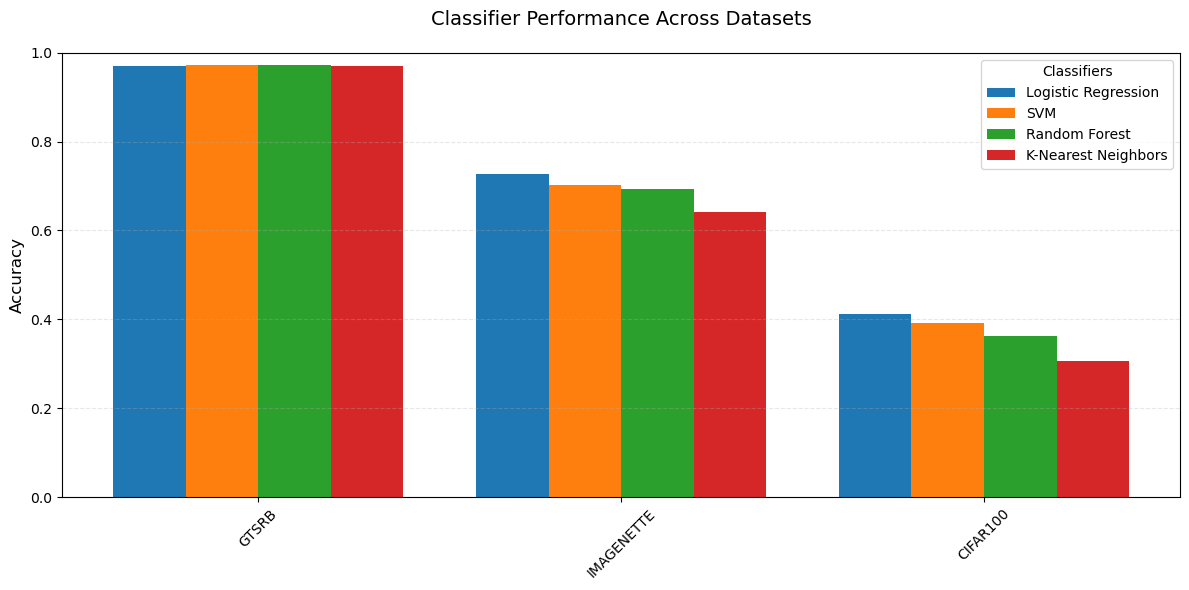

In [19]:
plot_results_from_directory()